# Generating class labels
We want to derive sentiment towards Mayors reasons for serious violent crime and there are 3 broad ways to do this:
- Sentiment analysis - extract the key words from the tweet and compare with a lexicon which matches words to sentiment. Derive an overall sentiment to the tweet based on it's aggregate sentiment polarity. Simplest, but not particularly accurate
- Supervised machine learning - use a corpus of tweets, which have been prelabeled as expressing one sentiment or another, to train a model which associates the features in the tweet with the designated sentiment. This has better accuracy but often tweets are manually labelled and that is very time consuming, labour intensive and subject to error.
- Use a graph/network based approach as a means to first assign sentiment at hashtag level, i.e. deduce sentiment based on the hashtags, and then propogate this sentiment to the tweetsusing those hashtags. Researchers have found they got better results when using collections of hashtags that appear together rather than individual hashtags, which they call hashtag cooccurrences, and this is the basis for the approach we will follow in this project.

The first step is to identify the hashtags which best express sentiment and that is the objective for this notebook.

## Hashtag coocurrences
I want to see which hashtags typically occur together with other hashtags, but only for the most important hashtags we identified previously. 
1. Create a subset of tweets containing the important hashtags and discard the rest:
- These are the important hashtags from tweets captured prior to 01/08/2021
    - #knifecrime
    - #crime
    - #stopandsearch
    - #police
    - #charliehebdo
    - #speakerscorner
    - #beatingcrimeplan
    - #policecuts
    - #austerity
    - #stabbing
2. Create a network of hashtags and their co-occurances
    - create a node for each hashtag
    - create an edge between hashtags to show they occured in the same tweet
    - give each edge a weight and a measure of how statistically significant it is
        - the weight is equal to the number of times it occurs i.e. if hashtag #a and #b occur together in 4 different tweets, then the edge (a -> b) will have weight = 4.
    
    
This notebook is heavily influenced by the work of Alexandre Bovet and we re-use some of his python code when deriving the probability and significance of each pair of hashtags co-occuring. 

## Revisit once we have all data from 4 weeks
- because we have a fraction of tweets containing hashtag that Bovet had
- and update hash

In [72]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
all_tweets = pd.read_csv("./DataSources/TwitterData/cleaned_tweets_20210821.csv")
print(all_tweets.shape)
all_tweets.head()

(39373, 25)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,...,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,28
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,...,['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,28
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,28
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,...,[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,28
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,...,[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,28


### Get percentage of tweets which used hashtags
Just a sense check of what we are dealing with

In [74]:
def check_for_hashtags(hashtags):
    if len(hashtags) == 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        return 0
    else:
        return 1

tweet_count = all_tweets.shape[0]

all_tweets['has_hashtag'] = 0
all_tweets['has_hashtag'] = all_tweets['hashtags'].apply(lambda x: check_for_hashtags(x))

tweets_with_hashtag_count = all_tweets['tweet_id'][all_tweets.has_hashtag == 1].count()

pct_tweet_with_hashtags = tweets_with_hashtag_count / tweet_count

print("Total number of tweets: {:,}\nTweets with one or more hashtags, total: {:,}\nTweets with one or more hashtags, percentage: {:.1%}".format(tweet_count,
                                                                                                            tweets_with_hashtag_count,
                                                                                                            pct_tweet_with_hashtags))

Total number of tweets: 39,373
Tweets with one or more hashtags, total: 2,395
Tweets with one or more hashtags, percentage: 6.1%


That's quite a low percentage of tweets containing hashtags and it will be lower still when we filter purely for tweets of interest.

### Important hashtags
- Below we have a list of hashtags we are interested in (list identified when analysing 1_7)

In [75]:
hashtag_list_20210801 = ['#knifecrime',
                '#crime',
                '#stopandsearch',
                '#police',
                '#charliehebdo',
                '#speakerscorner',
                '#beatingcrimeplan',
                '#policecuts',
                '#austerity',
                '#stabbing']

hashtag_list = hashtag_list_20210801

### Functions for identifying nodes and edges
It's worth describing the following functions to make it clear what they do
- We don't describe string_to_list() or contains_important_hashtags() as they are pretty self explanatory

#### get_hashtag_interactions(..)
For each tweet, find those containing hashtags of interest and, if present, return a list of each individual hashtag within the tweet. We use a set so that we only return a single instance of a hashtag even if it is repeated multiple times in that tweet.

#### get_all_edges(..) 
This is a recursive function that iteratively adds hashtag tuples to a list, where a single tuple describes two hashtags cooccuring in a single tweet. For example:
- consider a tweet containing hashtags #a #b and #c, return the following
    - [ (a,b), (a,c), (b,c) ]

In [76]:
def string_to_list(my_str):
    delimiter = ","
    my_str = my_str.replace("[", "")
    my_str = my_str.replace("]", "")
    my_str = my_str.replace("'", "")
    my_str = my_str.replace(" ", "")
    my_list = my_str.split(delimiter)
    return my_list

def contains_important_hashtags(hashtags, hashtag_list):
    is_present = any(item in hashtags for item in hashtag_list)
    
    if is_present is False:
        return None    
    else :
        return hashtags
    
def get_hashtag_interactions(tweet, hashtag_list):
    
    ret_val = contains_important_hashtags(tweet.hashtags, hashtag_list)
    
    if ret_val == None:
        return None
    else:
        
        interacting_hastags = set()
        
        my_hashtags = string_to_list(tweet.hashtags)
                
        for item in my_hashtags:
            interacting_hastags.add(item)
        
        return list(interacting_hastags)

def get_hashtags(tweet):
    
    if len(tweet.hashtags) == 2 : # a tweet with no hashtags contains [] and so len==2 means no hashtags
        return None
    else:
        
        my_hashtags = string_to_list(tweet.hashtags)
        
        all_hastags = set()       
                
        for item in my_hashtags:
            all_hastags.add(item)
        
        return list(all_hastags)
    
def get_all_edges(interactions):    
    
    # return if just one item left in the hashtag list
    if len(interactions) < 2:
        return None
    else:
        
        hashtag_relationships = []
        first_hashtag = interactions[0]
        remaining_hashtags = interactions[1:]

        for current_hashtag in remaining_hashtags:
            hashtag_relationships.append((first_hashtag, current_hashtag))
            
        other_hashtags = get_all_edges(remaining_hashtags)
        
        if other_hashtags != None:
            hashtag_relationships.extend(other_hashtags)
        
        return hashtag_relationships

### Now generate our full list of edges and assign weights
Using previously described functions, get a list of all hashtag pairs [source, target] and then group them by source and target to obtain a count of how many times these pairs occurred. This count is the weight for the edge and essentially describes the number of times this edge would have been traversed. 
- The code for this was reused from https://stackoverflow.com/questions/58803155/creating-a-weighted-network-from-co-occurence-of-hashtags-from-a-dataframe

Note that I also create a list of lists of hashtags (all_hashtags). This is so that I can create counts for how many times a hashtag appears across all tweets
- I need a different function because the results returned by the edges function contain multiple instances for a single hashtag if it cooccurs with more than one other hashtag and so isn't suitable for deriving the count of hashtags

In [77]:
all_hashtags = []
all_edges = []
for index, tweet in all_tweets.iterrows():
    
    current_hashtags = get_hashtags(tweet)
    
    if current_hashtags != None:
        all_hashtags.append(current_hashtags)
    
    interactions = get_hashtag_interactions(tweet, hashtag_list)
    if interactions != None:
        
        current_edges = get_all_edges(interactions)
        
        if current_edges != None:
            all_edges.extend(current_edges)

In [78]:
all_edges = [sorted(edge) for edge in all_edges]
all_edges[:10]

[['#hortonandwellington', '#knife'],
 ['#crime', '#knife'],
 ['#crime', '#hortonandwellington'],
 ['#khan', '#knife'],
 ['#knife', '#sadiq'],
 ['#crime', '#knife'],
 ['#khan', '#sadiq'],
 ['#crime', '#khan'],
 ['#crime', '#sadiq'],
 ['#knifecrime', '#london']]

In [79]:
all_hashtags_flat = [item for sublist in all_hashtags for item in sublist]
all_hashtags_flat[:10]

['#thegoodolddays',
 '#bikestormz',
 '#knivesdownbikesup',
 '#tllcch',
 '#kayburley',
 '#kayburley',
 '#skypapers',
 '#bikestormz',
 '#knivesdownbikesup',
 '#knife']

In [80]:
# create pandas dataframe
df_edges = pd.DataFrame(all_edges, columns=['source', 'target'])
df_edges.head()

,source,target
0,#hortonandwellington,#knife
1,#crime,#knife
2,#crime,#hortonandwellington
3,#khan,#knife
4,#knife,#sadiq


In [81]:
# create pandas dataframe
df_hashtags = pd.DataFrame(all_hashtags_flat, columns=['hashtag'])
df_hashtags_agg = pd.DataFrame({'count' : df_hashtags.groupby(['hashtag']).size()}).reset_index()

print(df_hashtags_agg.shape)
df_hashtags_agg.head()

(894, 2)


,hashtag,count
0,#abbott,1
1,#abdullahimohamoud,1
2,#acenewsdesk,1
3,#aclu,1
4,#action,3


In [82]:
# aggregate repeated edges
# c.f. https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe
df_edges_agg = pd.DataFrame({'count' : df_edges.groupby(['source', 'target']).size()}).reset_index()

print(df_edges_agg.shape)
df_edges_agg.head()

(753, 3)


,source,target,count
0,#acts17apologetics,#davidwood,3
1,#acts17apologetics,#hatuntash,3
2,#acts17apologetics,#londo,2
3,#acts17apologetics,#speakerscorner,3
4,#acts17apologetics,#stabbing,3


### Derive edge significance
df_edges_agg contains all the hashtag pairs together with how many times they appeared together in different tweets. We now want to derive the statistical signficance of these pairs because we want to ignore cooccurances that could happen by chance i.e. we want to be sure that these hashtags being placed together was an intentional act and their juxtaposition was intended to convey meaning. 

To do this we rely heavily on Bovet functions, which in turn implement the work of Marinez-Romo et al [3]

Martinez-Romo discuss describe how two words coocurring can be considered signficant if they cooccur more times than they would cooccur purely at random. They call this the null probability and, given a number of sets N in which we have two different words that occur n1 and n2 times, the <b> Null model </b> for these pairs occuring 'k' times can be described by the formula below.  

<img src="null_model_formula.png">

Bovet explains that we only want to keep significant edges whose probability of occuring the exact number of times we observed in our corpus, <code>p < p0</code>, where p0 a probability we define as equating to random chance (we use the same p0 value as Bovet, 1e-6). The significance is the given a weight 

<code>weight = log(p0/p)</code> 

#### calculate n1 and n2
How many times did hashtag #a occur and hashtag #b occur

In [83]:
df_edges_new = pd.merge(df_edges_agg, df_hashtags_agg, how='inner', left_on='source', right_on='hashtag')
df_edges_new = pd.merge(df_edges_new, df_hashtags_agg, how='inner', left_on='target', right_on='hashtag')
df_edges_new.rename(columns = {'count':'target_count'}, inplace = True)
df_edges_new.rename(columns = {'count_y':'source_count'}, inplace = True)
df_edges_new.rename(columns = {'count_x':'count'}, inplace = True)
df_edges_new.drop('hashtag_x', axis=1, inplace=True)
df_edges_new.drop('hashtag_y', axis=1, inplace=True)

print(df_edges_new.shape)
df_edges_new.head()

(753, 5)


,source,target,count,source_count,target_count
0,#acts17apologetics,#davidwood,3,3,3
1,#acts17apologetics,#hatuntash,3,3,8
2,#christianconcern,#hatuntash,1,3,8
3,#davidwood,#hatuntash,3,3,8
4,#free,#hatuntash,1,3,8


#### Bovet functions
The functions in the cell below are used verbatim from Bovet, though the p_val_np(..) function was tweaked to order n1, n2 by size

In [84]:
def first_seq(N,n1,j):
    return 1 - n1/(N-j)
    
def second_seq(N,n1,n2,k,j):
    return (n1-j)*(n2-j)/((N-n2+k-j)*(k-j))
    
def first_product_array(N,n1,n2,k):
    prod = np.ones(n2-k, dtype=np.float64)
    for j in range(0,n2-k-1+1):
        prod[j] = first_seq(N,n1,j)
    return prod

def second_product_array(N,n1,n2,k):
    prod = np.ones(k, dtype=np.float64)

    for j in range(0,k-1+1):
        prod[j] = second_seq(N,n1,n2,k,j)
    return prod
    
def p_val_np(N,n1,n2,r):
    
    # my tweak to swap the instance counts if n2 happens to be bigger than n1
    if n2 > n1:
        n3 = n1
        n1 = n2
        n2 = n3
        
    assert N>= n1 and n1 >= n2 and n2 >= r
    
    _sum = 0
    for k in range(r,n2+1):
        _sum += first_product_array(N,n1,n2,k).prod()*second_product_array(N,n1,n2,k).prod()
        
    return _sum

In [85]:
N = all_tweets.shape[0] # all tweets
p0=1e-6 # baseline probability

df_edges_new['probability'] = p0 # baseline small value
df_edges_new['significance'] = p0 # baseline small value

df_edges_new['probability'] = df_edges_new.apply(lambda row: p_val_np(N, row['target_count'], row['source_count'],
                                                                          row['count']),axis=1)

df_edges_new['significance'] = df_edges_new.apply(lambda row: np.log10(p0/row['probability']),axis=1)
                                         
df_edges_new = df_edges_new.copy()
    
df_edges_new.head()

,source,target,count,source_count,target_count,probability,significance
0,#acts17apologetics,#davidwood,3,3,3,9.830799e-14,7.007411
1,#acts17apologetics,#hatuntash,3,3,8,5.505247e-12,5.259223
2,#christianconcern,#hatuntash,1,3,8,6.094464e-04,-2.784936
3,#davidwood,#hatuntash,3,3,8,5.505247e-12,5.259223
4,#free,#hatuntash,1,3,8,6.094464e-04,-2.784936


### Now create our network and assign the weight, signficance and probabilty to each edge

In [86]:
import networkx as nx

G = nx.from_pandas_edgelist(df_edges_new, source='source', target='target', 
                            edge_attr=['count', 'probability', 'significance'])

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 230
Number of edges: 753
Average degree:   6.5478


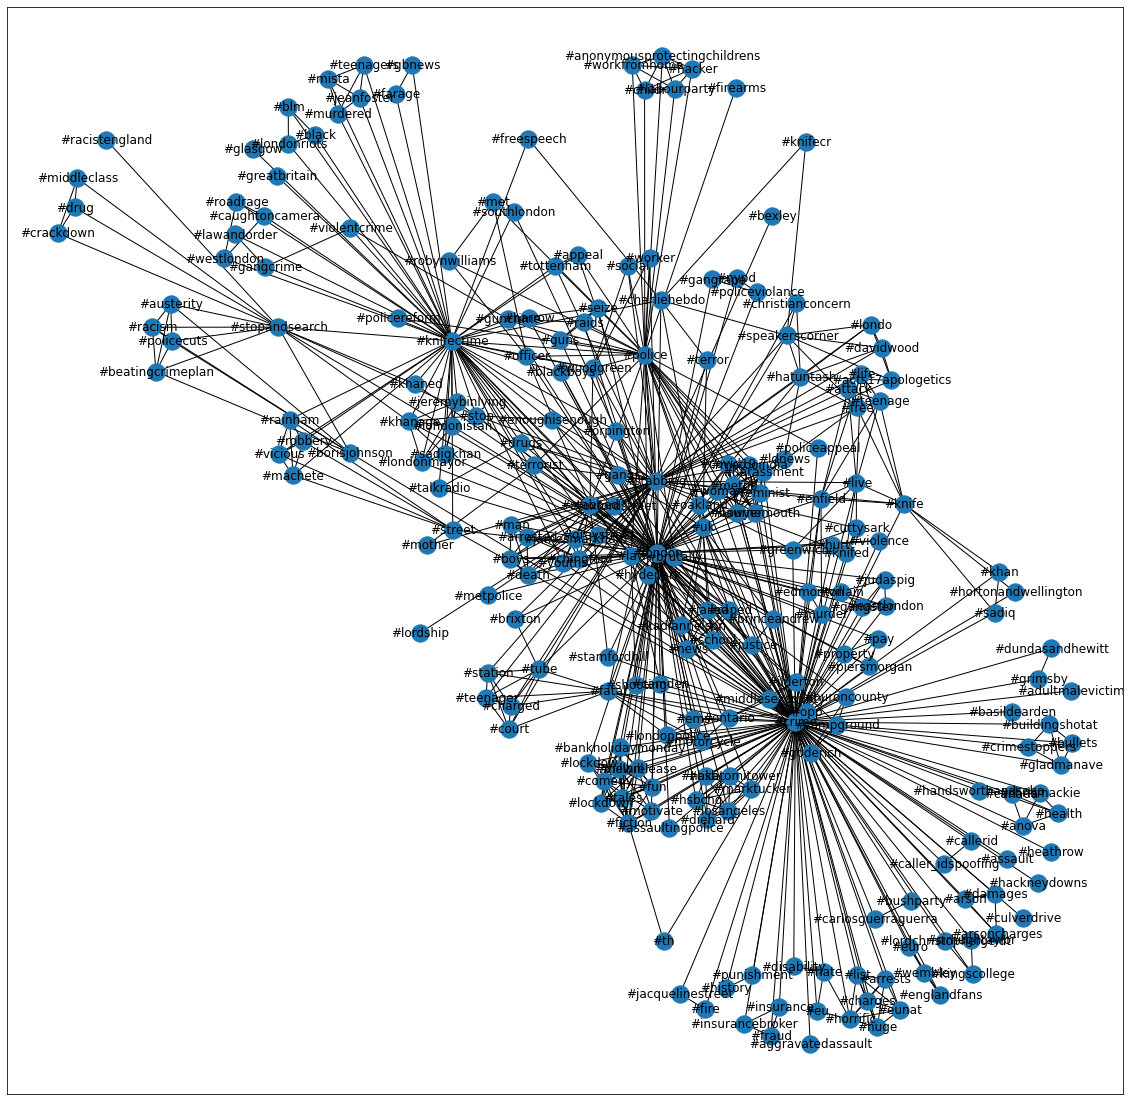

In [87]:
plt.figure(figsize=(20,20))
nx.draw_networkx(G)
plt.show()

### Visualise the edge attributes
- First via the network
- Then using the dataframe we used to create it

In [88]:
count = 0

for u,v,d in G.edges(data=True):
    if count < 10:
        print (u,v,d)
        count = count + 1
    else:
        print("breaking, count = {}".format(count))
        break

#acts17apologetics #davidwood {'count': 3, 'probability': 9.830799107117948e-14, 'significance': 7.007411178637212}
#acts17apologetics #hatuntash {'count': 3, 'probability': 5.505247499986052e-12, 'significance': 5.259223151631011}
#acts17apologetics #londo {'count': 2, 'probability': 3.870483916463408e-09, 'significance': 2.4122347328851728}
#acts17apologetics #speakerscorner {'count': 3, 'probability': 5.505247499986051e-11, 'significance': 4.259223151631011}
#acts17apologetics #stabbing {'count': 3, 'probability': 7.638530906230647e-10, 'significance': 3.1169901598362975}
#davidwood #hatuntash {'count': 3, 'probability': 5.505247499986052e-12, 'significance': 5.259223151631011}
#davidwood #londo {'count': 2, 'probability': 3.870483916463408e-09, 'significance': 2.4122347328851728}
#davidwood #speakerscorner {'count': 3, 'probability': 5.505247499986051e-11, 'significance': 4.259223151631011}
#davidwood #stabbing {'count': 3, 'probability': 7.638530906230647e-10, 'significance': 3.11

In [89]:
df_edges_new.sort_values(by='significance', ascending=False)[:20] 

,source,target,count,source_count,target_count,probability,significance
212,#knifecrime,#london,186,240,718,2.109388e-281,274.675844
174,#crime,#london,65,118,718,2.685696e-81,74.570943
665,#khanage,#stop,17,33,18,5.705550e-54,47.243702
310,#stop,#stopandsearch,17,18,35,2.218719e-53,46.653898
294,#beatingcrimeplan,#racism,12,12,12,3.456869e-47,40.461317
291,#beatingcrimeplan,#policecuts,12,12,12,3.456869e-47,40.461317
296,#policecuts,#racism,12,12,12,3.456869e-47,40.461317
335,#fiction,#newrelease,13,16,14,8.950463e-47,40.048154
287,#austerity,#beatingcrimeplan,12,13,12,4.493930e-46,39.347374
290,#austerity,#policecuts,12,13,12,4.493930e-46,39.347374


## Identify hashtags pro and against the Mayor on crime
What we want to do now is to link hashtags to sentiment, which which we mean we want to collect a list of hashtags that are either for or against mayors view on serious violent crime. We use the approach employed by Bovet, which is to manually identify seed hashtags as the basis for pro or contra views and then traverse our hashtag cooccurrance network looking for other hashtags which has a significant relationship with these hashtags. We define a signficant relationship as one where the probability is less than p0
- Bovet also removed hashtags which occurred less than 0.001*max(number of hashtag occurrences) but we don't have enough tweets with hashtags to require this additional filter

The seed hashtags we choose are as follows:
- #knifecrime, #khanage: class = AGAINST
- #stopandsearch, #racism: class = FOR

### First step is to filter the network so we only retain hashtags which have signficant relationships

In [90]:
df_edges_significant = df_edges_new[df_edges_new.probability < p0].copy()

print("Rows in original network: {}, rows in filtered network: {}".format(df_edges_new.shape[0],
                                                                          df_edges_significant.shape[0]))


Rows in original network: 753, rows in filtered network: 242


In [91]:
display(df_edges_significant[(df_edges_significant.source=='#knifecrime') |
                    (df_edges_significant.target=='#knifecrime')])

display(df_edges_significant[(df_edges_significant.source=='#stopandsearch') |
                    (df_edges_significant.target=='#stopandsearch')])

,source,target,count,source_count,target_count,probability,significance
135,#freespeech,#knifecrime,4,5,240,6.700217e-09,2.173911
143,#harrow,#knifecrime,7,9,240,1.020387e-14,7.991235
147,#khanage,#knifecrime,17,33,240,1.331941e-29,22.875515
212,#knifecrime,#london,186,240,718,2.109388e-281,274.675844
304,#knifecrime,#stopandsearch,17,240,35,5.124472e-29,22.290351
599,#knifecrime,#orpington,3,240,4,8.906733e-07,0.050282
666,#knifecrime,#stop,16,240,18,3.308071e-34,27.480425
674,#knifecrime,#violentcrime,3,240,3,2.236782e-07,0.650376
725,#knifecrime,#southlondon,3,240,3,2.236782e-07,0.650376


,source,target,count,source_count,target_count,probability,significance
297,#austerity,#stopandsearch,12,13,35,3.747945e-37,30.426207
298,#beatingcrimeplan,#stopandsearch,12,12,35,2.884591e-38,31.539916
299,#borisjohnson,#stopandsearch,12,18,35,5.337646e-34,27.272650
302,#khanage,#stopandsearch,17,33,35,1.428934e-45,38.844988
304,#knifecrime,#stopandsearch,17,240,35,5.124472e-29,22.290351
307,#policecuts,#stopandsearch,12,12,35,2.884591e-38,31.539916
308,#racism,#stopandsearch,12,12,35,2.884591e-38,31.539916
309,#racistengland,#stopandsearch,2,2,35,7.676460e-07,0.114839
310,#stop,#stopandsearch,17,18,35,2.218719e-53,46.653898


In [92]:
G_sig = nx.from_pandas_edgelist(df_edges_significant, source='source', target='target', 
                            edge_attr=['count', 'probability', 'significance'])

print(nx.info(G_sig))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 242
Average degree:   5.9024


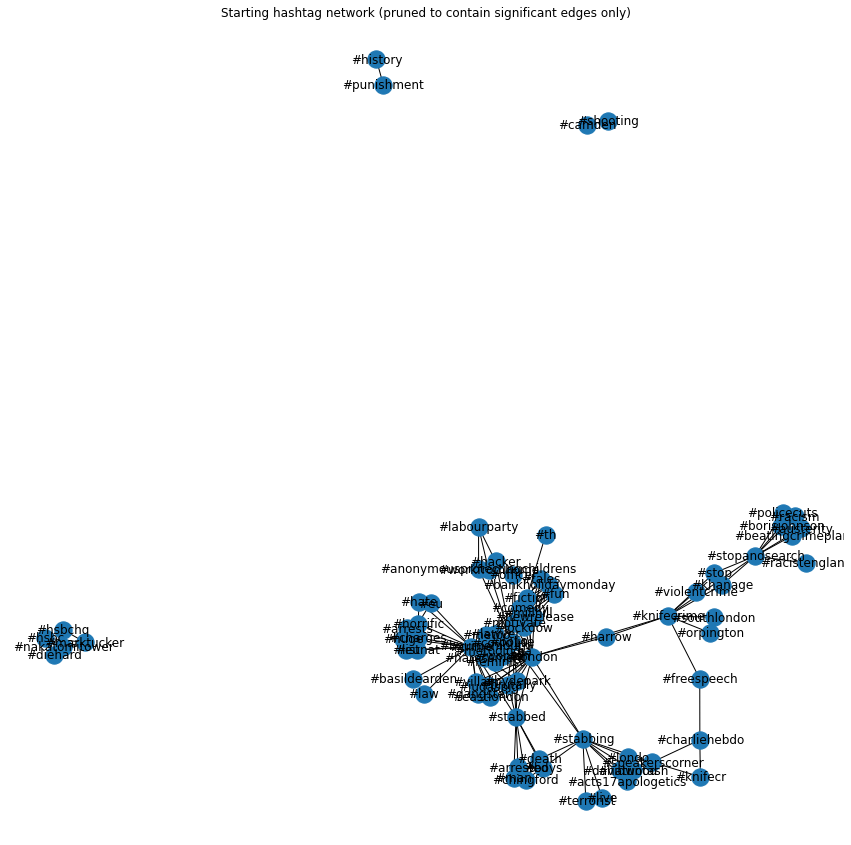

In [93]:
pos = nx.spring_layout(G_sig)

plt.figure(figsize=(15,15))
plt.title('Starting hashtag network (pruned to contain significant edges only)')
nx.draw_networkx(G_sig, pos)
plt.axis('off')
plt.show()

### Now we traverse the network, starting from our seed hashtags
We use Label propogation as the method of creating communities of similar hashtags. Based on research by Zhu and Ghahramani [4] they assume that nodes in a network are similar if they are near neighbours and they use proximity as a method to propogate labels from nodes with known labels to their neighbours with unknown labels. Bovet enhance this method by using the significance of the edge between two nodes to inform how to label an unlabelled node. For example:
- 1. unlabeled node n1 is linked to labeled nodes n2 (label=FOR) and n3 (label=AGAINST)
- 2. the significance of n1->n2 is 4.3 while the significance of n1->n3 is 3.2
- 3. node n1 is given label = FOR

If node n1 is linked to multiple nodes, some having label=FOR, others with label=AGAINST, then we sum the significance of all neighbouring nodes by class label and assign to n1 the label which corresponds with the highest aggregate significance.

### Pseudo code

1. assign labels to seed hashtags
2. start at a node, check out all edges - does it link to an neighbour with a label
    - if yes
        - if just one neighbour, give the node the same class
        - if more than one neighbour, do they also have class labels
            - if no, ignore other neighbours
            - if yes, sum weights and assign the class to this node based on greatest aggregate weight
    - if no
        - move to the next node, and the next, until we find a neighbour with a class
3. repeat until all nodes classified

#### Assign labels to seed hashtags

In [94]:
nodelist = list(G_sig.nodes.keys()) # get all keys
hashtag_dict = dict.fromkeys(nodelist,'') # initialise to ''

# set classes for seed hashtags
hashtag_dict['#knifecrime'] = 'AGAINST'
hashtag_dict['#khanage'] = 'AGAINST'
hashtag_dict['#stopandsearch'] = 'FOR'
hashtag_dict['#racism'] = 'FOR'

seed_hashtags = ['#knifecrime', '#khanage', '#stopandsearch', '#racism']

# add class label as a node attribute
nx.set_node_attributes(G_sig, hashtag_dict, 'class_label')

# see what the result is
class_node_list = []
for node in nodelist:
    class_node_list.append((node, G_sig.nodes[node]['class_label']))
    
sorted_class_node_list = sorted(class_node_list, key=lambda x:x[1], reverse=True) 
print(sorted_class_node_list[:10])

[('#racism', 'FOR'), ('#stopandsearch', 'FOR'), ('#knifecrime', 'AGAINST'), ('#khanage', 'AGAINST'), ('#acts17apologetics', ''), ('#davidwood', ''), ('#hatuntash', ''), ('#londo', ''), ('#speakerscorner', ''), ('#charliehebdo', '')]


#### Functions to propogate labels and visualise the results

In [95]:
# iterate through all nodes, get its edges, see whether they have labels and label this node based on the aggregate sum
# of its neighbours labels

def propogate_labels(class_node_list, G_sig, seed_hashtags):

    for current_node in class_node_list:
        
        # don't do anything if it's one of the seed nodes
        if current_node[0] in seed_hashtags:
            continue
    
        current_edges = G_sig.edges(current_node, data=True)
    
        for_val = 0;
        against_val = 0;
    
        for current_edge in current_edges:
            other_node = current_edge[1] # edge structure is (current node, adjacent node, data)
            other_class_label = G_sig.nodes[other_node]['class_label']
        
            edge_significance = current_edge[2]['significance']
        
            if other_class_label != '':
                if other_class_label == 'FOR':
                    for_val = for_val + edge_significance
                else: 
                    against_val = against_val + edge_significance
                
        if for_val > against_val:
            G_sig.nodes[current_node[0]]['class_label'] = 'FOR'
    
        if for_val < against_val:
            G_sig.nodes[current_node[0]]['class_label'] = 'AGAINST'
            
    return G_sig

def run_propogation(G, seed_hashtags, class_node_list, nodelist, pos, description):
    G = propogate_labels(class_node_list, G, seed_hashtags)
    
    classes = set(nx.get_node_attributes(G,'class_label').values())
    mapping = dict(zip(sorted(classes),count()))
    nodes = G.nodes()
    colors = [mapping[G.nodes[n]['class_label']] for n in nodes]


    title_str = description + ": after labels propogated"

    plt.figure(figsize=(15,15))
    plt.title(title_str)
    nx.draw_networkx(G, pos, nodelist=nodes, node_color=colors, 
                            with_labels=True, node_size=300, cmap=plt.cm.jet)

    plt.axis('off')
    plt.show()
    
    # reset class nodes based on updated network and see effect
    class_node_list = []
    for node in nodelist:
        class_node_list.append((node, G.nodes[node]['class_label']))
    
    sorted_class_node_list = sorted(class_node_list, key=lambda x:x[1], reverse=True) 
    print(sorted_class_node_list)
    
    return G, class_node_list

### Visualise the network with only seed hashtags colored according to their class label
Inspired by https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt

In [96]:
from itertools import count

classes = set(nx.get_node_attributes(G_sig,'class_label').values())
mapping = dict(zip(sorted(classes),count()))
nodes = G_sig.nodes()
colors = [mapping[G_sig.nodes[n]['class_label']] for n in nodes]

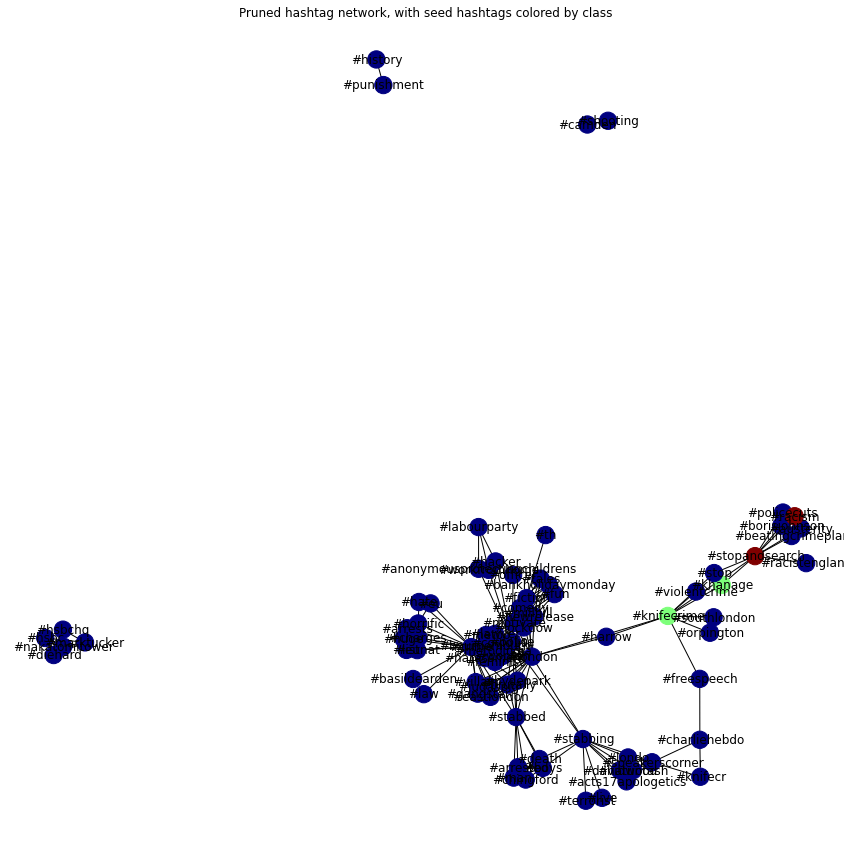

In [97]:
plt.figure(figsize=(15,15))
plt.title('Pruned hashtag network, with seed hashtags colored by class')

nx.draw_networkx(G_sig, pos, nodelist=nodes, node_color=colors, 
                            with_labels=True, node_size=300, cmap=plt.cm.jet)

plt.axis('off')
plt.show()

### Now propogate labels

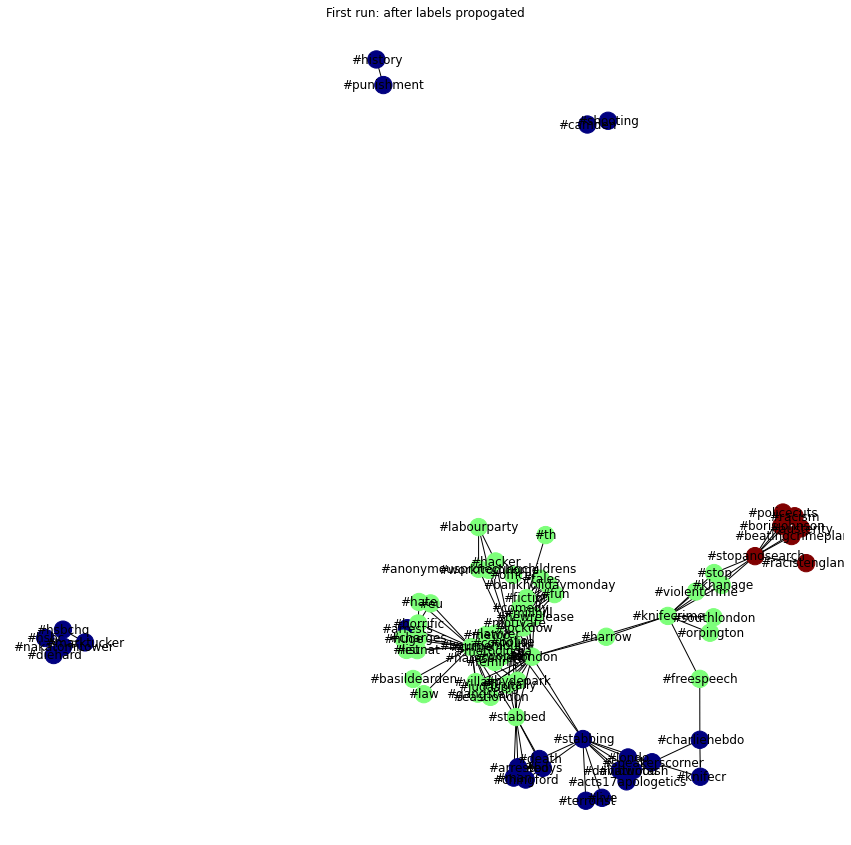

[('#austerity', 'FOR'), ('#beatingcrimeplan', 'FOR'), ('#borisjohnson', 'FOR'), ('#policecuts', 'FOR'), ('#racism', 'FOR'), ('#stopandsearch', 'FOR'), ('#racistengland', 'FOR'), ('#london', 'AGAINST'), ('#police', 'AGAINST'), ('#crime', 'AGAINST'), ('#basildearden', 'AGAINST'), ('#bournemouth', 'AGAINST'), ('#brutally', 'AGAINST'), ('#charges', 'AGAINST'), ('#comedy', 'AGAINST'), ('#covid19', 'AGAINST'), ('#anonymousprotectingchildrens', 'AGAINST'), ('#hacker', 'AGAINST'), ('#labourparty', 'AGAINST'), ('#feminist', 'AGAINST'), ('#harassment', 'AGAINST'), ('#hydepark', 'AGAINST'), ('#lawyer', 'AGAINST'), ('#metoo', 'AGAINST'), ('#metooindia', 'AGAINST'), ('#officer', 'AGAINST'), ('#workfromhome', 'AGAINST'), ('#freespeech', 'AGAINST'), ('#knifecrime', 'AGAINST'), ('#harrow', 'AGAINST'), ('#khanage', 'AGAINST'), ('#eastlondon', 'AGAINST'), ('#fiction', 'AGAINST'), ('#gangster', 'AGAINST'), ('#judaspig', 'AGAINST'), ('#stabbed', 'AGAINST'), ('#eunat', 'AGAINST'), ('#horrific', 'AGAINST'),

In [98]:
G_sig, class_node_list = run_propogation(G_sig, seed_hashtags, class_node_list, nodelist, pos, "First run")

### Comments
We haven't assigned labels to hashtags clustered around #charliehebdo, #speakerscorner so run again and see whether they get assigned

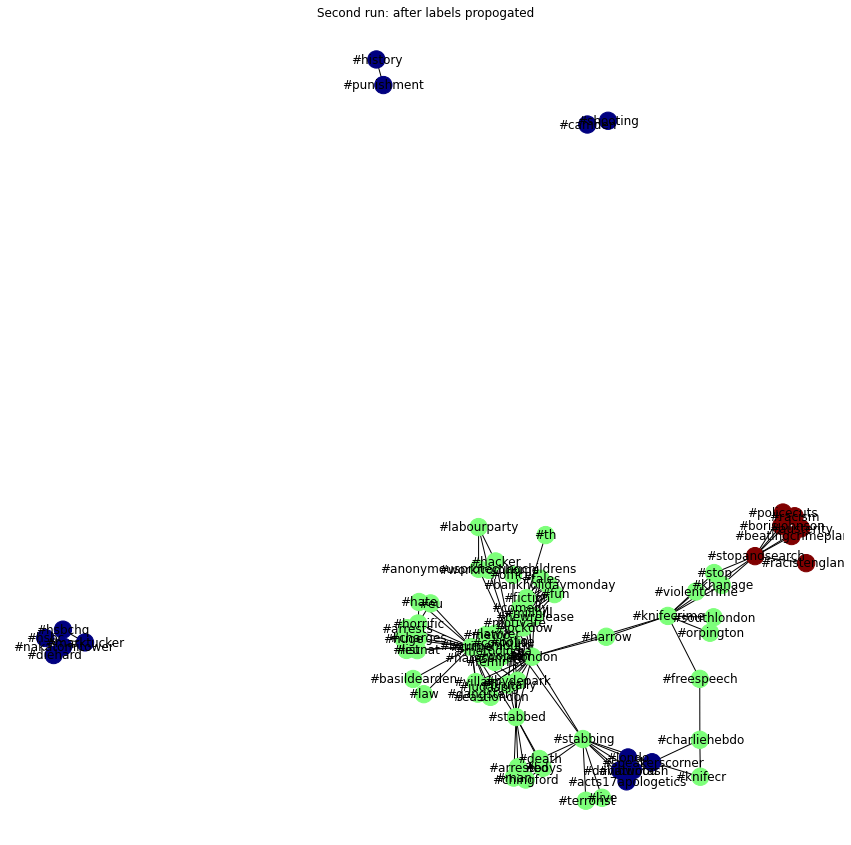

[('#austerity', 'FOR'), ('#beatingcrimeplan', 'FOR'), ('#borisjohnson', 'FOR'), ('#policecuts', 'FOR'), ('#racism', 'FOR'), ('#stopandsearch', 'FOR'), ('#racistengland', 'FOR'), ('#charliehebdo', 'AGAINST'), ('#knifecr', 'AGAINST'), ('#stabbing', 'AGAINST'), ('#boys', 'AGAINST'), ('#death', 'AGAINST'), ('#live', 'AGAINST'), ('#london', 'AGAINST'), ('#police', 'AGAINST'), ('#arrests', 'AGAINST'), ('#crime', 'AGAINST'), ('#basildearden', 'AGAINST'), ('#bournemouth', 'AGAINST'), ('#brutally', 'AGAINST'), ('#charges', 'AGAINST'), ('#comedy', 'AGAINST'), ('#covid19', 'AGAINST'), ('#anonymousprotectingchildrens', 'AGAINST'), ('#hacker', 'AGAINST'), ('#labourparty', 'AGAINST'), ('#feminist', 'AGAINST'), ('#harassment', 'AGAINST'), ('#hydepark', 'AGAINST'), ('#lawyer', 'AGAINST'), ('#metoo', 'AGAINST'), ('#metooindia', 'AGAINST'), ('#officer', 'AGAINST'), ('#workfromhome', 'AGAINST'), ('#freespeech', 'AGAINST'), ('#knifecrime', 'AGAINST'), ('#harrow', 'AGAINST'), ('#khanage', 'AGAINST'), ('#ar

In [99]:
G_sig, class_node_list = run_propogation(G_sig, seed_hashtags, class_node_list, nodelist, pos, "Second run")

### Comments
Still some hashtags unassigned so run again

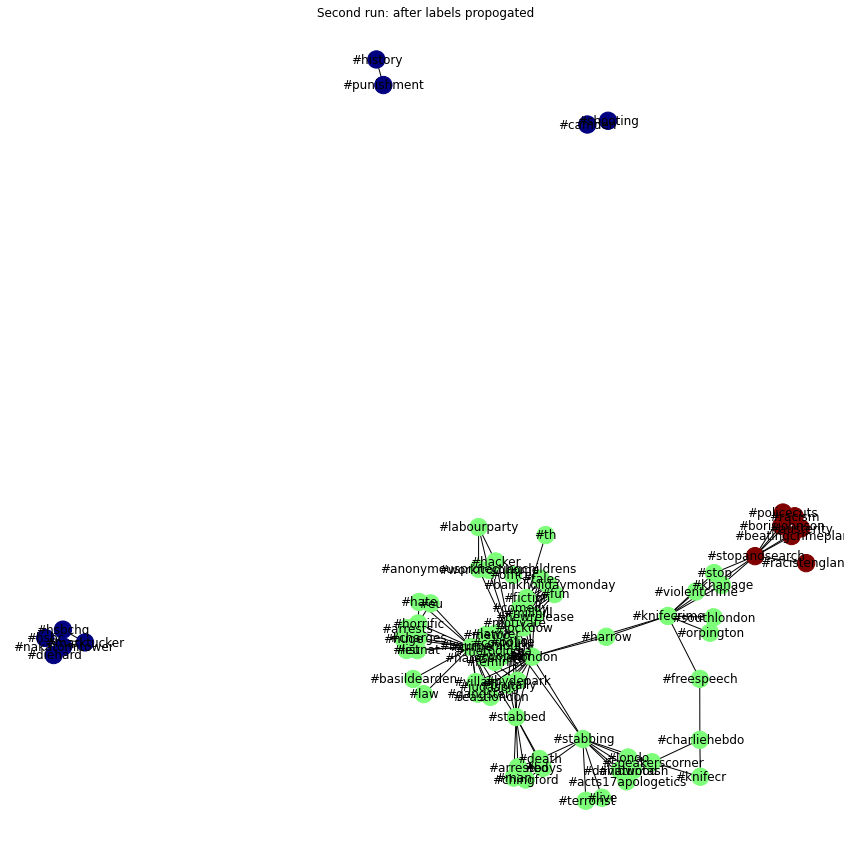

[('#austerity', 'FOR'), ('#beatingcrimeplan', 'FOR'), ('#borisjohnson', 'FOR'), ('#policecuts', 'FOR'), ('#racism', 'FOR'), ('#stopandsearch', 'FOR'), ('#racistengland', 'FOR'), ('#acts17apologetics', 'AGAINST'), ('#davidwood', 'AGAINST'), ('#hatuntash', 'AGAINST'), ('#londo', 'AGAINST'), ('#speakerscorner', 'AGAINST'), ('#charliehebdo', 'AGAINST'), ('#knifecr', 'AGAINST'), ('#stabbing', 'AGAINST'), ('#boys', 'AGAINST'), ('#death', 'AGAINST'), ('#live', 'AGAINST'), ('#london', 'AGAINST'), ('#police', 'AGAINST'), ('#arrests', 'AGAINST'), ('#crime', 'AGAINST'), ('#basildearden', 'AGAINST'), ('#bournemouth', 'AGAINST'), ('#brutally', 'AGAINST'), ('#charges', 'AGAINST'), ('#comedy', 'AGAINST'), ('#covid19', 'AGAINST'), ('#anonymousprotectingchildrens', 'AGAINST'), ('#hacker', 'AGAINST'), ('#labourparty', 'AGAINST'), ('#feminist', 'AGAINST'), ('#harassment', 'AGAINST'), ('#hydepark', 'AGAINST'), ('#lawyer', 'AGAINST'), ('#metoo', 'AGAINST'), ('#metooindia', 'AGAINST'), ('#officer', 'AGAINST

In [100]:
G_sig, class_node_list = run_propogation(G_sig, seed_hashtags, class_node_list, nodelist, pos, "Second run")

## Comments
All hashtags assigned labels where reasonable and results look quite encouraging because we know nakatomi is an outlier and the rest seem reasonably assigned. It's clear label assignment is heavily influenced by the classes I assigned to the seed hashtags, but that's to be expected and desirable.  
- See Appendix B for a worked examples for label propogation code

In [101]:
# create DataFrame using data
labeled_hashtags_df = pd.DataFrame(class_node_list, columns =['hashtag', 'class_label'])
labeled_hashtags_df = labeled_hashtags_df[labeled_hashtags_df.class_label.isin(['AGAINST', 'FOR'])]
labeled_hashtags_df.sort_values(by='class_label', ascending=False)

,hashtag,class_label
55,#stopandsearch,FOR
54,#racism,FOR
53,#policecuts,FOR
52,#borisjohnson,FOR
51,#beatingcrimeplan,FOR
...,...,...
24,#feminist,AGAINST
23,#labourparty,AGAINST
22,#hacker,AGAINST
21,#anonymousprotectingchildrens,AGAINST


## Community detection
We've identified clusters of cooccurring hashtags using label propagation but another potential approach is community detection, which is a method for identifying the different clusters or communities that exist within a network. Bovet also used this approach to verify his cooccurrance results and we will use the <b>greedy modularity method provided with the Networkx library</b> [5], which implements Clauset-Newman-Moore greedy modularity maximization [6]. 

A community in a network can be broadly describes as a set of members (nodes/vertices) which have a greater density of links (edges) between them than they have with other communities or nodes within the network. However, traversing every node and vertice combination in order to identify which combinations produce the greatest density is computationally expensive and not feasible for large networks [7]. Newman [7] and Clauset et all [6] describe an alternative approach, based on the concept of community modularity. In their approach the network characteristics (density, average number of edges per node) are used to derive a measure for an expected edge density within a randomly created community and then they subtract this from the edge density calculated for the current collection of nodes and they call the resulting quantity the community modularity. This means the higher the modularity, the greater the difference in density between this collection and what we would expect at random, and hence the more confidence we have that this community is real.
- Newman defines modularity as '<code>the number of edges falling within groups <b>minus</b> the expected number in an equivalent network with edges placed at random, and 'without regard for the community structure'</code>'. 
- Newman goes on to explain that simply trying to optimise modularity by calculating it for all community permutations still results in a exponential calculation, which is still infeasible when applied to large networks. They therefore propose their greedy optimisation algorithm
- In their greedy approach, communities start as individual vertices and double in size to create wider communities and at each step they take forward only those communities which produce the greatest increase in modularity. In addition, their approach allows them to ignore potential joins because they do not need to join with communities with which they don't have have connecting edges. These optimisations reduce the algorithmic overhead from exponential to quadratic [7] and in sparce networks (with fewer intercommunity links) reduces the computation from quadratic to near log linear [6]. This means their algorithm can scale for larger networks.
- It should be noted that their results compare reasonably well with community detection methods that don't use greedy optimisation [7].

In [102]:
from operator import itemgetter
from networkx.algorithms import community 

communities = community.greedy_modularity_communities(G_sig)

In [103]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G_sig, modularity_dict, 'modularity')

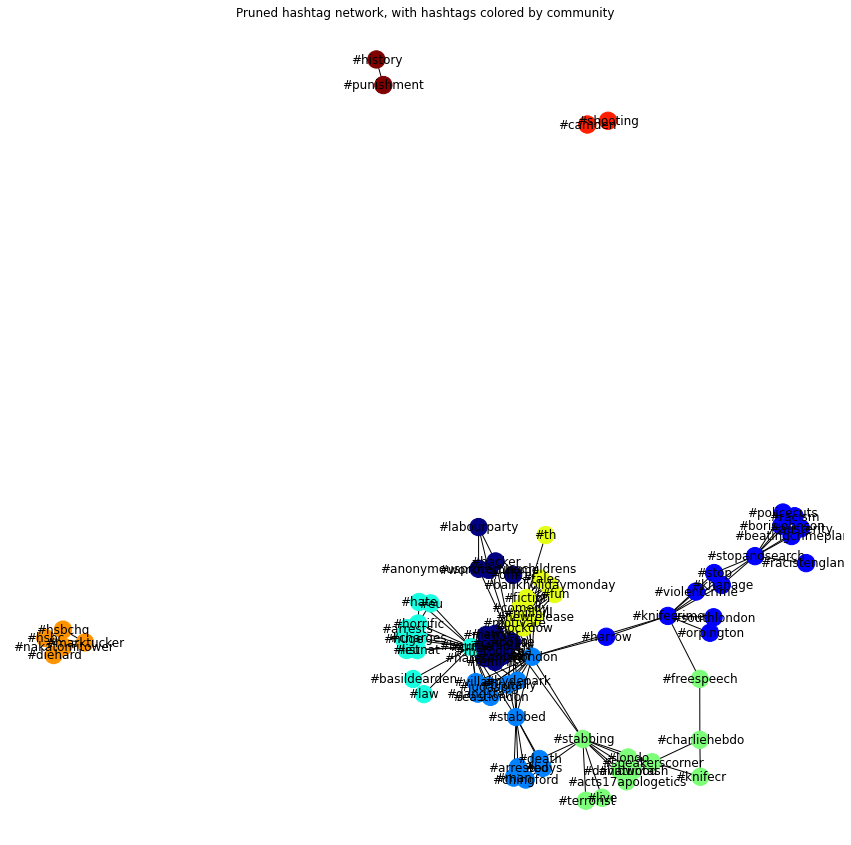

In [104]:
mod_classes = set(nx.get_node_attributes(G_sig,'modularity').values())
mod_mapping = dict(zip(sorted(mod_classes),count()))
mod_nodes = G_sig.nodes()
mod_colors = [mod_mapping[G_sig.nodes[n]['modularity']] for n in nodes]

plt.figure(figsize=(15,15))
plt.title('Pruned hashtag network, with hashtags colored by community')

nx.draw_networkx(G_sig, pos, nodelist=mod_nodes, node_color=mod_colors, 
                            with_labels=True, node_size=300, cmap=plt.cm.jet)

plt.axis('off')
plt.show()

### Comments - this needs work
Community gives a more granular response and it's clear we have hashtags that shouldn't be in our list but also it's clear that the label propogation has benefits to - I think a combination of the two helps us identify which we should use.

In [105]:
df_modularity = pd.DataFrame(list(modularity_dict.items()), columns = ['hashtag', 'community_id'])
all_hashtags = pd.merge(labeled_hashtags_df, df_modularity, how='inner', left_on='hashtag', right_on='hashtag')

import datetime
today = datetime.datetime.today().strftime('%Y%m%d')

outputfile_str = "./DataSources/TwitterData/important_hashtags_" + today + ".csv"
print(outputfile_str)

all_hashtags.to_csv(outputfile_str, index=False)

all_hashtags

./DataSources/TwitterData/important_hashtags_20210821.csv


,hashtag,class_label,community_id
0,#acts17apologetics,AGAINST,4
1,#davidwood,AGAINST,4
2,#hatuntash,AGAINST,4
3,#londo,AGAINST,4
4,#speakerscorner,AGAINST,4
...,...,...,...
68,#th,AGAINST,5
69,#villain,AGAINST,2
70,#violentcrime,AGAINST,1
71,#southlondon,AGAINST,1


# Appendices

## Appendix A - References

- [1] Bovet, A., Morone, F. and Makse, H.A., 2018. Validation of Twitter opinion trends with national polling aggregates: Hillary Clinton vs Donald Trump. Scientific reports, 8(1), pp.1-16.
- [2] https://github.com/alexbovet/twitter_opinion_mining
- [3] Martinez-Romo, J., Araujo, L., Borge-Holthoefer, J., Arenas, A., Capitán, J.A. and Cuesta, J.A., 2011. Disentangling categorical relationships through a graph of co-occurrences. Physical Review E, 84(4), p.046108.
- [4] Zhu, X., Ghahramani, 2002. Learning from labeled and unlabeled data with label propagation.
- [5] https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html. 
- [6] Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.
- [7] Newman, M.E., 2004. Fast algorithm for detecting community structure in networks. Physical review E, 69(6), p.066133.

## Appendix B - Label Propogation testing
We test our label propogation algorithm with very simple datasets to confirm it works as expected. 

### First set up test functions

In [ ]:
def create_df(example_network):
    df_example_network = pd.DataFrame(example_network, columns = ['source', 'target', 'count', 'source_count', 
                                                              'target_count', 'probability', 'significance'])

    return df_example_network

def create_initial_net(df_example_network, description):
    G_example = nx.from_pandas_edgelist(df_example_network, source='source', target='target', 
                            edge_attr=['count', 'probability', 'significance'])

    print(nx.info(G_example))
    
    pos_example = nx.spring_layout(G_example)
    
    title_str = description + ": initial network"

    plt.figure(figsize=(6,6))
    plt.title(title_str)
    nx.draw_networkx(G_example, pos_example, node_size=750)
    plt.axis('off')
    plt.show()

    return G_example, pos_example

def assign_seed_labels(G_example, for_seeds, against_seeds, description, pos_example):
    nodelist_example = list(G_example.nodes.keys()) # get all keys
    node_example_dict = dict.fromkeys(nodelist_example,'') # initialise to ''

    # set classes for seed hashtags
    for seed in for_seeds:
        node_example_dict[seed] = 'FOR'
        
    for seed in against_seeds:
        node_example_dict[seed] = 'AGAINST'

    # add class label as a node attribute
    nx.set_node_attributes(G_example, node_example_dict, 'class_label')
    
    # reset class nodes based on updated network and see effect
    class_node_list = []
    for node in nodelist_example:
        class_node_list.append((node, G_example.nodes[node]['class_label']))
    
    sorted_class_node_list = sorted(class_node_list, key=lambda x:x[1], reverse=True) 
    print(sorted_class_node_list)
    
    classes = set(nx.get_node_attributes(G_example,'class_label').values())
    mapping = dict(zip(sorted(classes),count()))
    nodes = G_example.nodes()
    colors = [mapping[G_example.nodes[n]['class_label']] for n in nodes]


    title_str = description + ": seed labels assigned"

    plt.figure(figsize=(6,6))
    plt.title(title_str)
    nx.draw_networkx(G_example, pos_example, nodelist=nodes, node_color=colors, 
                            with_labels=True, node_size=750, cmap=plt.cm.jet)

    plt.axis('off')
    plt.show()
    
    return G_example, class_node_list, nodelist_example

def test_propogation(G_example, seed_hashtags_example, class_node_list, description, pos_example, nodelist_example):
    G_example = propogate_labels(class_node_list, G_example, seed_hashtags_example)
    
    classes = set(nx.get_node_attributes(G_example,'class_label').values())
    mapping = dict(zip(sorted(classes),count()))
    nodes = G_example.nodes()
    colors = [mapping[G_example.nodes[n]['class_label']] for n in nodes]

    title_str = description + ": after labels propogated"

    plt.figure(figsize=(6,6))
    plt.title(title_str)
    nx.draw_networkx(G_example, pos_example, nodelist=nodes, node_color=colors, 
                            with_labels=True, node_size=750, cmap=plt.cm.jet, font_color='white')

    plt.axis('off')
    plt.show()
    
    # reset class nodes based on updated network and see effect
    class_node_list = []
    for node in nodelist_example:
        class_node_list.append((node, G_example.nodes[node]['class_label']))
    
    sorted_class_node_list = sorted(class_node_list, key=lambda x:x[1], reverse=True) 
    print(sorted_class_node_list)
    
    return G_example, class_node_list
    
def test_network(example_network, for_seeds, against_seeds, seed_hashtags_example, description):
    
    df_example_network = create_df(example_network)
    G_example, pos_example = create_initial_net(df_example_network, description)
    G_example, class_node_list, nodelist_example = assign_seed_labels(G_example, for_seeds, against_seeds, 
                                                    description, pos_example)
    G_example, class_node_list = test_propogation(G_example, seed_hashtags_example, class_node_list, 
                                                  description, pos_example, nodelist_example)
    
    return G_example, class_node_list, pos_example, nodelist_example

### Appendix 2.1 - label one node based on significance with multiple neighbours
Imagine we have an unlabelled node <code> F </code> which is surrounded by five labeled nodes <code> A, B, C, D, E </code>. We want to label F based on its relationships with it's neighbours and we do this by summing up the significance of the links between F and each of it's neighbours and we assign F with the label corresponding to the highest aggregate signficance. In this case we would expect F to be given the label 'AGAINST'

<img src="weighted_network_example_1.png">

In [ ]:
example_network = [['A', 'F', 1, 1, 1, 1, 1],
                  ['B', 'F', 1, 1, 1, 1, 2],
                  ['C', 'F', 1, 1, 1, 1, 3],
                  ['D', 'F', 1, 1, 1, 1, 3],
                  ['E', 'F', 1, 1, 1, 1, 4],]

for_seeds = ['A','B','D']
against_seeds = ['C','E']

seed_hashtags_example = for_seeds + against_seeds

G_example, class_node_list, pos_example, nodelist_example = test_network(example_network, for_seeds, 
                                                                         against_seeds, seed_hashtags_example, 
                                                                         "Example 2.1")

#### Comments
Working as expected

### Appendix 2.2 - label one node based on significance with multiple neighbours, one neighbour unlabeled
Imagine we have two unlabelled nodes <code> F and A </code> F is surrounded by 4 labeled nodes <code> B, C, D, E </code> and the significance of its relationships with C and E mean it should be given the same labels as then, i.e. AGAINST

<img src="weighted_network_example_2.png">

In [ ]:
# example_network same as before

for_seeds = ['B','D']
against_seeds = ['C','E']

seed_hashtags_example = for_seeds + against_seeds

G_example, class_node_list, pos_example, nodelist_example = test_network(example_network, for_seeds, 
                                                                         against_seeds, seed_hashtags_example, 
                                                                         "Example 2.2")

#### Comments
F is labelled correctly but A is left hanging. Rerun propogation to see what happens

In [ ]:
G_example, class_node_list = test_propogation(G_example, seed_hashtags_example, class_node_list, "Example 2.2", pos_example, nodelist_example)

#### Comments
A is now labeled, correctly based on its relationship with F.

### Appendix 2.3 - only one node labeled, all it's neighbours unlabeled
Imagine we have 5 unlabelled nodes <code> A, B, C, D, E </code> and one labeled node <code> F </code> - we would expect   A->E to be given the same labels as F

<img src="weighted_network_example_3.png">

In [ ]:
# example_network same as before

for_seeds = ['F']
against_seeds = ['']

seed_hashtags_example = for_seeds + against_seeds

G_example, class_node_list, pos_example, nodelist_example = test_network(example_network, for_seeds, 
                                                                         against_seeds, seed_hashtags_example, 
                                                                         "Example 2.3")

#### Comments
Works as expected

### Appendix 2.4 - two unlabeled nodes, hanging off another node which has relationships with labeled nodes
<code> Central node F unlabeled </code> but should be labeled based on its relationship with 4 labeled nodes surrounding it <code> B, C, D, E </code>. Once F is labelled we would then expect <code>nodes A, G, H to be labelled based on their relationship with F </code>

<img src="weighted_network_example_4.png">

In [ ]:
example_network = [['A', 'F', 1, 1, 1, 1, 1],
                  ['B', 'F', 1, 1, 1, 1, 2],
                  ['C', 'F', 1, 1, 1, 1, 3],
                  ['D', 'F', 1, 1, 1, 1, 3],
                  ['E', 'F', 1, 1, 1, 1, 4],
                  ['G', 'A', 1, 1, 1, 1, 2],
                  ['H', 'A', 1, 1, 1, 1, 2]]

for_seeds = ['B','D']
against_seeds = ['C','E']

seed_hashtags_example = for_seeds + against_seeds

G_example, class_node_list, pos_example, nodelist_example = test_network(example_network, for_seeds, 
                                                                         against_seeds, seed_hashtags_example, 
                                                                         "Example 2.4")

#### Comments
F has been assigned, correctly, but A, G, H left hanging so run again

In [ ]:
G_example, class_node_list = test_propogation(G_example, seed_hashtags_example, class_node_list, "Example 2.4 (run 2)", pos_example, nodelist_example)

#### Comments
All assigned correctly now

### Appendix 2.5 - Hanging node labeled based on relationship with central node
<code> Both G and F </code> should be labeled the same based on their relationship with <code> E </code>

<img src="weighted_network_example_5.png">

In [ ]:
example_network = [['A', 'F', 1, 1, 1, 1, 1],
                  ['B', 'F', 1, 1, 1, 1, 2],
                  ['C', 'F', 1, 1, 1, 1, 3],
                  ['D', 'F', 1, 1, 1, 1, 3],
                  ['E', 'F', 1, 1, 1, 1, 4],
                  ['G', 'E', 1, 1, 1, 1, 4],]

for_seeds = ['A','B','D']
against_seeds = ['C','E']

seed_hashtags_example = for_seeds + against_seeds

G_example, class_node_list, pos_example, nodelist_example = test_network(example_network, for_seeds, 
                                                                         against_seeds, seed_hashtags_example, 
                                                                         "Example 2.5")

### Comments
As expected.